In [2]:
import pandas as pd
import numpy as np

def preprocess(filename):
    df = []
    with open(filename, 'r') as f:
        for line in f:
            rec = {}
            items = line.split()
            rec['relevance'] = int(items[0])
            rec['qid'] = int(items[1].split(':')[1])
            rec['features'] = [float(items[i].split(':')[1]) for i in range(2,2+46)]
            rec['docid'] = items[50]
            df.append(rec)
    df = pd.DataFrame(df)
    return df
    

df_train = preprocess('MQ2007/Fold1/train.txt')
df_valid = preprocess('MQ2007/Fold1/vali.txt')
df_test = preprocess('MQ2007/Fold1/test.txt')

In [3]:
df_train.head()

,relevance,qid,features,docid
0,0,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",GX000-00-0000000
1,1,10,"[0.03131, 0.666667, 0.5, 0.166667, 0.033206, 0...",GX000-24-12369390
2,1,10,"[0.078682, 0.166667, 0.5, 0.333333, 0.080022, ...",GX000-62-7863450
3,1,10,"[0.019058, 1.0, 1.0, 0.5, 0.022591, 0.0, 0.0, ...",GX016-48-5543459
4,0,10,"[0.039477, 0.0, 0.75, 0.166667, 0.040555, 0.0,...",GX037-87-3082362


In [4]:
import matplotlib.pyplot as plt

# Dataset vis

In [4]:
df_test['relevance'].drop_duplicates()

0     0
1     1
17    2
Name: relevance, dtype: int64

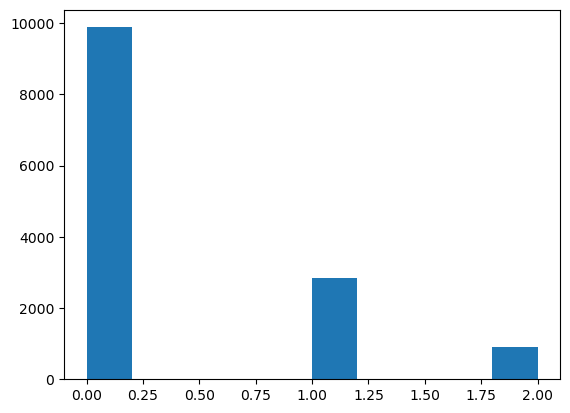

In [5]:
plt.hist(df_test['relevance'].values);

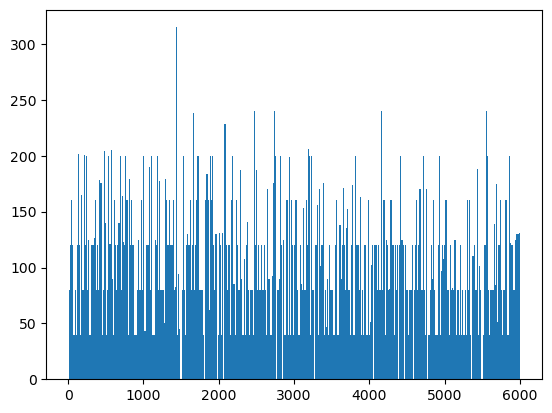

In [6]:
plt.hist(df_train['qid'], bins=400);

In [7]:
df_train['qid'].drop_duplicates()

0          10
40         15
80         33
120        34
160        37
         ... 
41977    5981
42027    5988
42067    5989
42078    5996
42118    6000
Name: qid, Length: 1017, dtype: int64

In [8]:
df_test['qid'].drop_duplicates()

0        7968
40       7979
80       7993
120      7995
170      8002
         ... 
13452    9991
13492    9992
13532    9994
13572    9997
13612    9999
Name: qid, Length: 336, dtype: int64

In [9]:
df_train['docid'].drop_duplicates().sort_values()

0         GX000-00-0000000
17444     GX000-00-0305363
40200     GX000-00-0398421
16965     GX000-00-0665119
12046     GX000-00-0972746
               ...        
6978     GX272-82-16261892
31224     GX272-82-9021746
32309    GX272-83-12234283
16638     GX272-83-7556847
32064     GX272-84-8558203
Name: docid, Length: 40231, dtype: object

In [10]:
df_test['docid'].drop_duplicates().sort_values()

0         GX000-00-0000000
80       GX000-00-12630903
7248     GX000-00-13190733
81       GX000-00-14019140
13293     GX000-00-2625598
               ...        
8496      GX272-77-6290069
409       GX272-78-3686656
12331     GX272-81-5549787
10565    GX272-82-11657440
4449     GX272-82-14104919
Name: docid, Length: 13302, dtype: object

# Linear Model

In [9]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

def train(model:linear_model.LinearRegression, dataset:pd.DataFrame):
    features = np.stack(dataset['features'])
    model.fit(features, dataset['relevance'])
    return model.coef_

def predict(model:linear_model.LinearRegression, dataset:pd.DataFrame):
    features = np.stack(dataset['features'])
    return model.predict(features)
    
    
def evaluate(model:linear_model.LinearRegression, dataset:pd.DataFrame):
    pred_rels = predict(model, dataset)
    return np.sqrt(np.mean(np.square(dataset['relevance']-pred_rels)))
    # return model.score(features, dataset['relevance'])


train(reg, df_train)

print("train loss", evaluate(reg, df_train))
print("test loss", evaluate(reg, df_test))

result = pd.DataFrame({"predict":predict(reg, df_train), "true": df_train['relevance']})
result.head()

train loss 0.5367111742584176
test loss 0.5813998908904527


,predict,true
0,-0.012137,0
1,0.660603,1
2,0.544658,1
3,0.750844,1
4,0.491347,0


Text(0, 0.5, 'predicted relevance')

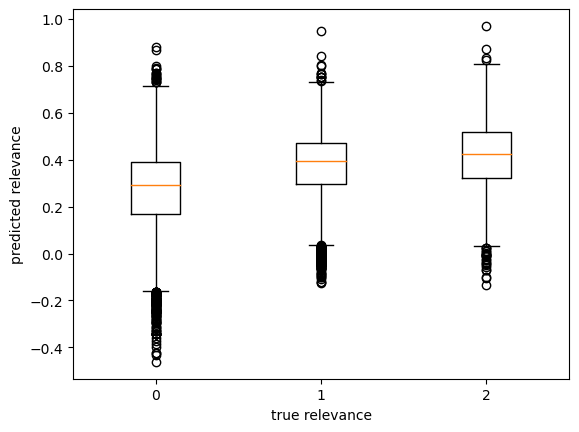

In [29]:
rel = result['true'].drop_duplicates().values
pred_rels = [np.array(result[result['true'] == x]['predict']) for x in rel]
plt.boxplot(pred_rels, labels=rel)
plt.xlabel("true relevance")
plt.ylabel("predicted relevance")


In [30]:
diffs = [np.sqrt(np.mean(np.square(pred_rels[i] - rel[i]))) for i in range(len(rel))]
diffs

[0.31778370285125646, 0.6363955882358779, 1.5947846815944617]

# Metrics

In [10]:
# NDCG@10
    
def DCG(relevance_list):
        factor = np.log2(np.arange(2, len(relevance_list)+2))
        numenator = np.power(2, relevance_list)-1
        return np.sum(numenator/factor)
    
def NDCGatK(model, dataset, k=10):
    qids = dataset['qid'].drop_duplicates()
    results = []
    for qid in qids:
        filtered_ds = dataset[dataset['qid']==qid].copy()
        features = np.stack(filtered_ds['features'])

        filtered_ds['pred_relevance'] = model.predict(features)
        ideal = filtered_ds.sort_values('relevance', inplace=False, ascending=False)['relevance'][:k]
        idealDCG = DCG(ideal)
        real = filtered_ds.sort_values('pred_relevance', inplace=False, ascending=False)['relevance'][:k]
        realDCG = DCG(real)
        if idealDCG != 0:
            results.append(realDCG/idealDCG)
        # else:
        #     results.append(1)
    return np.mean(results)


In [11]:
NDCGatK(reg, df_test), NDCGatK(reg, df_train), 

(0.523303338860965, 0.4936030128505534)

linear model baseline:\
test, train = (0.52, 0.49)

In [12]:
def NDCGatK_torch(model, pred_func, dataset, k=10):
    qids = dataset['qid'].drop_duplicates()
    results = []
    for qid in qids:
        filtered_ds = dataset[dataset['qid']==qid].copy()

        filtered_ds['pred_relevance'] = pred_func(model, filtered_ds)
        ideal = filtered_ds.sort_values('relevance', inplace=False, ascending=False)['relevance'][:k]
        idealDCG = DCG(ideal)
        real = filtered_ds.sort_values('pred_relevance', inplace=False, ascending=False)['relevance'][:k]
        realDCG = DCG(real)
        if idealDCG != 0:
            results.append(realDCG/idealDCG)
        # else:
        #     results.append(1)
    return np.mean(results)

In [13]:
NDCGatK_torch(reg, predict, df_test), NDCGatK_torch(reg, predict, df_train)

(0.523303338860965, 0.4936030128505534)

# RankNet

In [14]:
dtype = np.float32

In [15]:
featureN = len(df_train['features'][0])
featureN

46

In [16]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

In [124]:
class MyModule(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.lin1 = nn.Linear(featureN, 10)
        self.lin3 = nn.Linear(10, 1)
    def forward(self, input):
        x = torch.sigmoid(self.lin1(input))
        # x = torch.sigmoid(self.lin2(x))
        x = 2*torch.sigmoid(self.lin3(x))
        return x.squeeze(-1)
    

class MyDataset(Dataset):
    def __init__(self, dataFrame):
        super().__init__()
        self.dataFrame = dataFrame
        
    def __len__(self):
        return len(self.dataFrame)
    
    def __getitem__(self, index):
        
        x = np.array(self.dataFrame['features'].values[index], dtype=dtype)

        y = dtype(self.dataFrame['relevance'].values[index])
        return x, y
    
trainloader = DataLoader(MyDataset(df_train), batch_size=1024,
                                          shuffle=True)

testloader = DataLoader(MyDataset(df_test), batch_size=1024,
                                         shuffle=False)

model = MyModule()
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
history = []

In [125]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    processed_data = 0
    model.train()

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    
    return train_loss     

def predict(model, dataFrame, batch_size=100):
    data_loader = DataLoader(MyDataset(dataFrame), batch_size=batch_size, shuffle=False)

    model.eval()
    result = []
    with torch.set_grad_enabled(False):
        for inputs, labels in data_loader:
            outputs = model(inputs)
            result.extend(outputs.tolist())
            
    return np.array(result, dtype=dtype)


In [126]:
# def eval_epoch(model, dataFrame, criterion, batch_size=100):

#     with torch.set_grad_enabled(False):
#         pred = predict(model, dataFrame)
#         # loss = criterion(pred, torch.from_numpy(dataFrame['relevance'].values))
#         metrics = NDCGatK_torch(model, dataFrame)
#     return metrics # loss, 
    
def train(train_data, test_data, model, epochs, batch_size, optimizer, criterion):
    train_loader = DataLoader(MyDataset(train_data), batch_size=batch_size, shuffle=True)
    history = []
    log_template = "\nEpoch {ep:03d} train_acc {t_acc:0.4f} test_acc {v_acc:0.4f}"
    with tqdm(total=epochs) as pbar:
        for epoch in range(epochs):
            fit_epoch(model, train_loader, criterion, optimizer)
            train_acc = NDCGatK_torch(model, predict, train_data)
            val_acc = NDCGatK_torch(model, predict, test_data)
            pbar.set_postfix_str(log_template.format(ep=epoch, t_acc=train_acc, v_acc=val_acc))
            history.append((train_acc, val_acc))
            yield (train_acc, val_acc)
            
            pbar.update()                
    # return history

In [ ]:
for h in train(df_train, df_test, model, 7, 100, optim, loss_fn):
    history.append(h)

In [ ]:
plt.plot(history, label=['train_met', 'test_met'])
plt.legend()
plt.xlabel("epochs")
plt.title("NDCG@10 accuracy");

complex model

In [74]:
class MyModule2(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.lin1 = nn.Linear(featureN, 40)
        self.lin2 = nn.Linear(40, 40)
        self.lin3 = nn.Linear(40, 40)
        self.lin4 = nn.Linear(40, 40)
        self.lin5 = nn.Linear(40, 10)
        self.lin_last = nn.Linear(10, 1)
    def forward(self, input):
        x = torch.sigmoid(self.lin1(input))
        x = torch.sigmoid(self.lin2(x))
        x = torch.sigmoid(self.lin3(x))
        x = torch.sigmoid(self.lin4(x))
        x = torch.sigmoid(self.lin5(x))
        x = self.lin_last(x)
        return x.squeeze(-1)

model = MyModule2()
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-2)
history = []

In [78]:
for h in train(df_train, df_test, model, 7, 100, optim, loss_fn):
    history.append(h)

  0%|          | 0/7 [00:00<?, ?it/s]

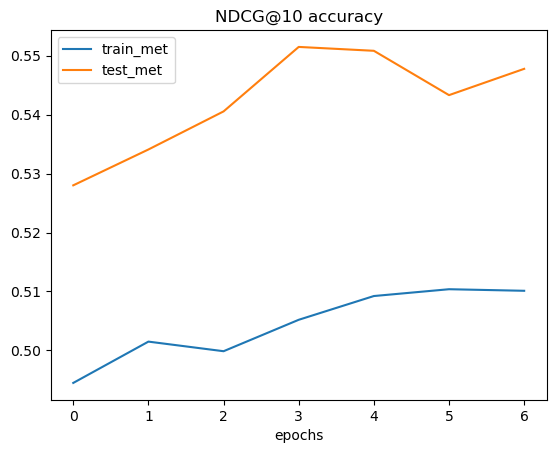

In [76]:
plt.plot(history, label=['train_met', 'test_met'])
plt.legend()
plt.xlabel("epochs")
plt.title("NDCG@10 accuracy");

нелинейные модели достигают токого же качества в (0.54, 52)

### pairwise loss.

In [80]:
df_train['qid'].value_counts()

2297    147
3134    113
1439    109
1665    108
2343    108
       ... 
1921     40
6000     40
5715     11
5989     11
3394      6
Name: qid, Length: 1017, dtype: int64

In [81]:
np.sum(np.square(df_train['qid'].value_counts()))

1809850

In [82]:
np.sum(df_train['qid'].value_counts())

42158

In [83]:
1809850/42158

42.930167465249774

чтобы не слишком долго учиться, будем выбирать только $D$ пар из $D^2$ для каждого запроса.

априорные веросятности $P( f(x_i)$ > $f(x_j)  )$ приближаю $\sigma(rel_i - rel_j)$

In [128]:

class PairDataset(Dataset):
    def __init__(self, dataFrame):
        super().__init__()
        self.dataFrame = dataFrame
        self.filtered_df = {}
        qids = dataFrame['qid'].drop_duplicates()
        for qid in qids:
            filtered_df = dataFrame[dataFrame['qid']==qid]
            self.filtered_df[qid] = filtered_df

    def __len__(self):
        return len(self.dataFrame)
    
    def __getitem__(self, index):
        
        qid = self.dataFrame['qid'].values[index]
        
        paired_x_id = np.random.choice(self.filtered_df[qid].index)
        paired_x = self.filtered_df[qid]['features'][paired_x_id]
        paired_y = self.filtered_df[qid]['relevance'][paired_x_id]
        
        x = self.dataFrame['features'].values[index]

        y = dtype(self.dataFrame['relevance'].values[index])
        return np.array([x, paired_x], dtype=dtype), y - paired_y

class MyModule2(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.lin1 = nn.Linear(featureN, 40)
        self.lin2 = nn.Linear(40, 40)
        self.lin3 = nn.Linear(40, 40)
        self.lin4 = nn.Linear(40, 40)
        self.lin5 = nn.Linear(40, 10)
        self.lin_last = nn.Linear(10, 1)
    def forward(self, input):
        x = torch.sigmoid(self.lin1(input))
        x = torch.sigmoid(self.lin2(x))
        x = torch.sigmoid(self.lin3(x))
        x = torch.sigmoid(self.lin4(x))
        x = torch.sigmoid(self.lin5(x))
        x = self.lin_last(x)
        return x.squeeze(-1)

model = MyModule2()
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
history = []

loss_fn = nn.BCEWithLogitsLoss()

In [134]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    processed_data = 0
    model.train()

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(torch.sigmoid(labels), outputs[..., 0]-outputs[..., 1])
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    
    return train_loss     
def train(train_data, test_data, model, epochs, batch_size, optimizer, criterion):
    train_loader = DataLoader(PairDataset(train_data), batch_size=batch_size, shuffle=True)
    history = []
    log_template = "\nEpoch {ep:03d} train_acc {t_acc:0.4f} test_acc {v_acc:0.4f}"
    with tqdm(total=epochs) as pbar:
        for epoch in range(epochs):
            fit_epoch(model, train_loader, criterion, optimizer)
            train_acc = NDCGatK_torch(model, predict, train_data)
            val_acc = NDCGatK_torch(model, predict, test_data)
            pbar.set_postfix_str(log_template.format(ep=epoch, t_acc=train_acc, v_acc=val_acc))
            history.append((train_acc, val_acc))
            yield (train_acc, val_acc)
            
            pbar.update()                
    # return history

In [136]:
for h in train(df_train, df_test, model, 7, 100, optim, loss_fn):
    history.append(h)

  0%|          | 0/7 [00:00<?, ?it/s]

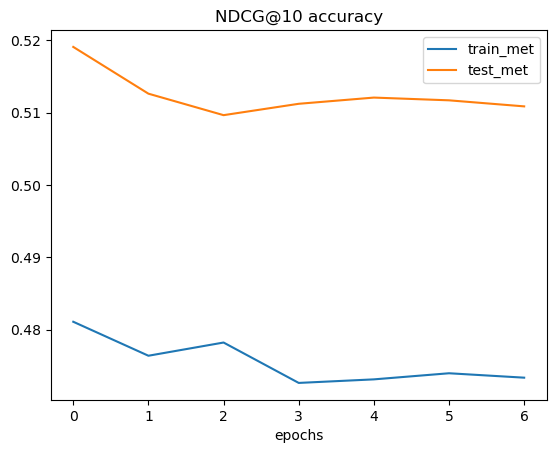

In [137]:
plt.plot(history, label=['train_met', 'test_met'])
plt.legend()
plt.xlabel("epochs")
plt.title("NDCG@10 accuracy");

похожая точность (0.51, 0.47)

Теперь априорная вероятность бинарна.

In [143]:
a = torch.rand(2, 2)
print(a)
print((a>0).float())

tensor([[0.5676, 0.6847],
        [0.9539, 0.4621]])
tensor([[1., 1.],
        [1., 1.]])


In [144]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    processed_data = 0
    model.train()

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn((labels>0).float(), outputs[..., 0]-outputs[..., 1])
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    
    return train_loss 

In [145]:
model = MyModule2()
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
history = []

In [146]:
for h in train(df_train, df_test, model, 7, 100, optim, loss_fn):
    history.append(h)

  0%|          | 0/7 [00:00<?, ?it/s]

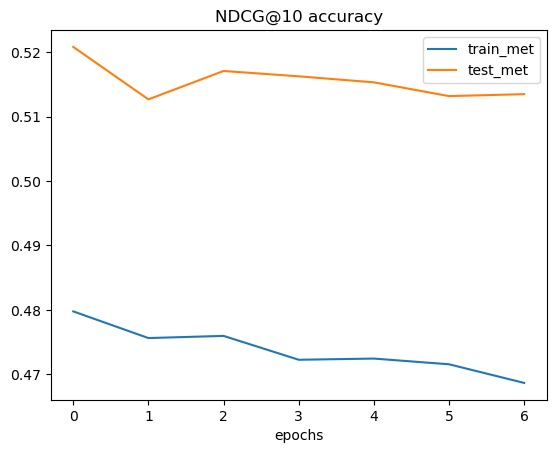

In [147]:
plt.plot(history, label=['train_met', 'test_met'])
plt.legend()
plt.xlabel("epochs")
plt.title("NDCG@10 accuracy");

Такой же результат. Получается, результат не зависит от преобразования relevance score-ов.